In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.preprocessing import StandardScaler


In [2]:
# mapping labels to 0 to 3 for all the four classes
labmap = {0: "n02089078-black-and-tan_coonhound"
          ,1: "n02091831-Saluki"
          ,2:"n02092002-Scottish_deerhound"
          ,3:"n02095314-wire-haired_fox_terrier"} 

# giving the paths of the cropped images 
paths = [r'../DataSet/ProcessedDatasets/n02089078-black-and-tan_coonhound/'
         ,r'../DataSet/ProcessedDatasets/n02091831-Saluki/'
         ,r'../DataSet/ProcessedDatasets/n02092002-Scottish_deerhound/'
         ,r'../DataSet/ProcessedDatasets/n02095314-wire-haired_fox_terrier/']


data_set = [] # empty array to save the dataset
labels = [] # empty array to save the labels

# 1. loop to convert the images to gray scale pixel intensity histograms and save the labels and the dataset
for i in paths:
    for dog in os.listdir(i):
        img = cv2.imread(i + dog,cv2.IMREAD_GRAYSCALE)
        hist = cv2.calcHist(img, [0], None, [256], [0, 256])
        data_set.append(hist)
        labels.append(paths.index(i))

# 2. standardize the data set 
standard_dset = StandardScaler().fit_transform(np.array(data_set)[:,:,0])

# convert the python list to a numpy array for appending it to the data
labels = np.array(labels)
# final data that consists of the normalized data and labels.
final_data = np.column_stack((standard_dset, labels))

In [3]:
from sklearn.model_selection import train_test_split

# referred from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = [], [], [], []

# 3. loop to split training and testing data to 80/20 percent
for i in labmap.keys():
    class_indices = np.where(labels == i)[0]
    X_class = standard_dset[class_indices]
    y_class = labels[class_indices]
    X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class, y_class, test_size=0.2)
    X_train.extend(X_train_class)
    X_test.extend(X_test_class)
    Y_train.extend(Y_train_class)
    Y_test.extend(Y_test_class)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


In [4]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# list of k values to iterate through
k_values = [1, 3, 5, 7, 10, 20]

# Lists of validation and training errors for standard 5-fold cross-validation
standard_validation_errors = []
standard_training_errors = []

num_folds = 5

for k in k_values:
    # creating a k-NN classifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # performing standard 5-fold cross-validation
    scores = cross_val_score(knn, X_train, Y_train, cv=num_folds)
    
    standard_validation_errors_k = 1- scores
    knn.fit(X_train, Y_train)
    Y_pred_train = knn.predict(X_train)
    training_error_k = 1 - (Y_pred_train == Y_train).mean()
    
    # Append errors to the respective lists
    standard_training_errors.append(training_error_k)
    standard_validation_errors.append(standard_validation_errors_k.mean())

print(f'validation errors  = {standard_validation_errors}')
print(f'training errors  = {standard_training_errors}')


validation errors  = [0.7002240896358544, 0.7470868347338936, 0.7102100840336134, 0.6967787114845938, 0.7017927170868348, 0.70187675070028]
training errors  = [0.0, 0.39698492462311563, 0.490787269681742, 0.5326633165829145, 0.5326633165829145, 0.6080402010050252]


In [5]:

# Lists of validation and training errors for stratified 5-fold cross-validation
stratified_validation_errors = []
stratified_training_errors = []
best_k_values = []

kf = StratifiedKFold(n_splits=num_folds)

for k in k_values:
    validation_errors = []
    training_errors = []
    for train_index, val_index in kf.split(X_train, Y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

        knn = KNeighborsClassifier(n_neighbors=k) 
        knn.fit(X_train_fold, Y_train_fold)

        validation_error = 1 - knn.score(X_val_fold, y_val_fold)
        training_error = 1 - knn.score(X_train_fold, Y_train_fold)

        validation_errors.append(validation_error)
        training_errors.append(training_error)

    mean_validation_error = np.mean(validation_errors)
    mean_training_error = np.mean(training_errors)

    stratified_validation_errors.append(mean_validation_error)
    stratified_training_errors.append(mean_training_error)

    best_k = k_values[np.argmin(stratified_validation_errors)]
    best_k_values.append(best_k)




Best k for Standard Validation Error: 7
Best k for Standard Training Error: 1
Best k for Stratified Validation Error: 7
Best k for Stratified Training Error: 1


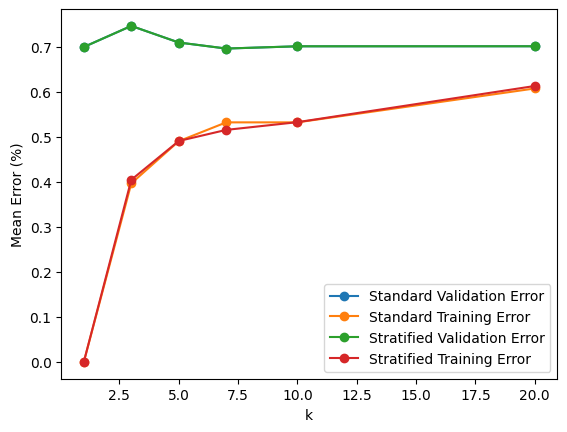

In [6]:
import matplotlib.pyplot as plt



# Plot the validation and training error curves for standard 5-fold cross-validation
plt.plot(k_values, standard_validation_errors, label='Standard Validation Error', marker='o')
plt.plot(k_values, standard_training_errors, label='Standard Training Error', marker='o')

# Plot the validation and training error curves for stratified 5-fold cross-validation
plt.plot(k_values, stratified_validation_errors, label='Stratified Validation Error', marker='o')
plt.plot(k_values, stratified_training_errors, label='Stratified Training Error', marker='o')

# Label the axes and add a legend
plt.xlabel('k')
plt.ylabel('Mean Error (%)')
plt.legend()

# Find the best k for each curve
best_k_standard_validation = k_values[standard_validation_errors.index(min(standard_validation_errors))]
best_k_standard_training = k_values[standard_training_errors.index(min(standard_training_errors))]
best_k_stratified_validation = k_values[stratified_validation_errors.index(min(stratified_validation_errors))]
best_k_stratified_training = k_values[stratified_training_errors.index(min(stratified_training_errors))]

# Print the best k values for each curve
print(f'Best k for Standard Validation Error: {best_k_standard_validation}')
print(f'Best k for Standard Training Error: {best_k_standard_training}')
print(f'Best k for Stratified Validation Error: {best_k_stratified_validation}')
print(f'Best k for Stratified Training Error: {best_k_stratified_training}')

# Show the plot
plt.show()


In [7]:
knn = KNeighborsClassifier(n_neighbors=best_k)

# Train the k-NN classifier on the entire training dataset
knn.fit(X_train, Y_train)

# Evaluate the model on the test dataset and calculate the test error
Y_pred_test = knn.predict(X_test)
test_error = 1 - (Y_pred_test == Y_test).mean()  # Test error in terms of misclassification rate

print(f'Test Error with k={best_k}: {test_error * 100:.2f}%')

Test Error with k=7: 70.86%
